# Voxelmorph training Notebook

Largely inspired by [Voxelmorph's notebook tutorial](https://colab.research.google.com/drive/1WiqyF7dCdnNBIANEY80Pxw_mVz4fyV-S?usp=sharing#scrollTo=Fw6dKBjBPXNp).

In [3]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# suppress info and warn TF logs
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import time
import cv2
import tifffile as tiff
import numpy as np
import matplotlib
import voxelmorph as vxm
import tensorflow as tf
import nibabel as nib
import neurite as ne
from matplotlib import pyplot as plt
from IPython.display import Video

plt.rcParams["animation.html"] = "jshtml" 
plt.rcParams["animation.embed_limit"] = "500"  # size limit in MB

# Font size
plt.style.use('default')

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%reload_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

In [1]:
from stabilize2p.utils import make_video

def frame_gen(video, scores=None, lt=0.9):
    std = video[0].std()
    print('calculated std')
    low = np.quantile(video[0], q=0.01)
    if scores is not None:
        for img, score in zip(video, scores):
            img = (img - low) / std * 255 / 3
            img[img < 0] = 0
            img[img > 255] = 255
            img = img.astype(np.uint8)
            if score < lt:
                img[:50, :50] = 255
            else:
                img[:50, :50] = 0
            yield img
    else:
        for img in video:
            img = (img - low) / std * 255 / 3
            img[img < 0] = 0
            img[img > 255] = 255
            img = img.astype(np.uint8)
            yield img

In [2]:
orig_examples = [
    '../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/006_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/007_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/008_coronal/2p/denoised_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/009_coronal/2p/denoised_red.tif'
]

ofco_examples = [
    '../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/warped_red.tif',
    '../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/warped_red.tif'
]

pystackreg_examples = [
    '../data/200901_G23xU1/Fly1/Fly1/001_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/002_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/003_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/004_coronal/2p/denoised_red.pystackreg-affine.tif',
    '../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.pystackreg-affine.tif'
]

RANDOM_SEED = 1

In [5]:
from stabilize2p.utils import vxm_data_generator

# RAW score

Normalized,

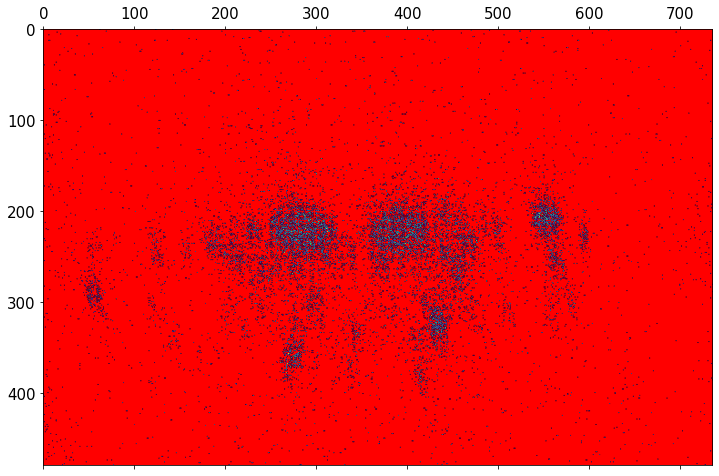

In [17]:
from stabilize2p import threshold
image = tiff.imread('../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/red.tif', key=2101)

th = threshold.triangle(image)
mask = image < th
np.clip(image, th, None, out=image)
image = image - th

_, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.matshow(image)
mask = np.tile(mask.astype(float)[..., np.newaxis], (1, 1, 4))
mask[..., [1, 2]] = 0.0
ax.imshow(mask)
plt.show()

In [ ]:
from stabilize2p.metrics import MSE
path = orig_examples[4]
print(f'{path=}')
x = tiff.imread(path)
low, hig = x.min(), x.max()
x = (x - low) / (hig - low)
MSE(x)

path='../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.tif'


0.0011008003632525442

triangle threshold applied,

In [34]:
from stabilize2p import threshold
from stabilize2p.metrics import MSE
path = orig_examples[4]
print(f'{path=}')
x = tiff.imread(path)

t1 = time.perf_counter()
low, hig = x.min(), x.max()
x = (x - low) / (hig - low)
th = threshold.triangle(x)
np.clip(x, th, None, out=x)
x = x - th
t2 = time.perf_counter()
print(f'Elapsed {t2-t1:.2f}s | '
      f'{x.shape[0]/(t2-t1):,.0f} frames/s | {(t2-t1)/x.shape[0]:.4g} s/frame')

MSE(x)

path='../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.tif'
Elapsed 11.50s | 357 frames/s | 0.002805 s/frame


0.0008905347172271271

# COM + ECC affine

In [26]:
from stabilize2p.utils import vxm_preprocessing

path = orig_examples[4]
print(f'{path=}')
x = tiff.imread(path)

t1 = time.perf_counter()
x, _ = vxm_preprocessing(x)
t2 = time.perf_counter()
print(f'Elapsed {t2-t1:.2f}s | '
      f'{x.shape[0]/(t2-t1):,.0f} frames/s | {(t2-t1)/x.shape[0]:.4g} s/frame')

make_video('out', frame_gen(x))
Video('out.mov')

path='../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.tif'
Elapsed 111.93s | 37 frames/s | 0.0273 s/frame
calculated std


4100it [00:12, 340.38it/s]
ffmpeg: /home/adrian/miniconda3/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


converting video..
Done (16.60s)


In [27]:
from stabilize2p.metrics import MSE
MSE(x)

0.0004632697

## Fully-Conv NN

In [ ]:
from stabilize2p.utils import get_strategy
strategy = get_strategy('GPU')

In [8]:
# retrieve dataset shape
PATH = orig_examples[0]
in_shape = tiff.imread(PATH, key=0).shape

In [16]:
# configure unet features 
nb_features = [
    [16, 32, 32, 128, 128],         # encoder features
    [128, 128, 32, 32, 32, 16, 16]  # decoder features
]

# build model using VxmDense
with strategy.scope():
    vxm_model = vxm.networks.VxmDense(in_shape, nb_features, int_steps=0)

In [17]:
vxm_model.summary(line_length = 180)

Model: "vxm_dense"
____________________________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                              Output Shape                            Param #              Connected to                                                
 vxm_dense_source_input (InputLayer)                       [(None, 480, 736, 1)]                   0                    []                                                          
                                                                                                                                                                                    
 vxm_dense_target_input (InputLayer)                       [(None, 480, 736, 1)]                   0                    []                                                          
                                                                            

In [15]:
print('input shape: ', ', '.join([str(t.shape) for t in vxm_model.inputs]))
print('output shape:', ', '.join([str(t.shape) for t in vxm_model.outputs]))

input shape:  (None, 480, 736, 1), (None, 480, 736, 1)
output shape: (None, 480, 736, 1), (None, 480, 736, 2)


## Loss

In [37]:
# voxelmorph has a variety of custom loss classes
losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]

# usually, we have to balance the two losses by a hyper-parameter
lambda_param = 0.05
loss_weights = [1, lambda_param]

In [38]:
# (batch_size, *vol_shape, nb_feats)
shape = (1, 10, 10, 1)
vxm.losses.NCC().loss(tf.ones(shape), tf.zeros(shape)).numpy()

array([-0.04000058], dtype=float32)

## Compile model

In [49]:
with strategy.scope():
    vxm_model.compile(optimizer='Adam', loss=losses, loss_weights=loss_weights)

## Train

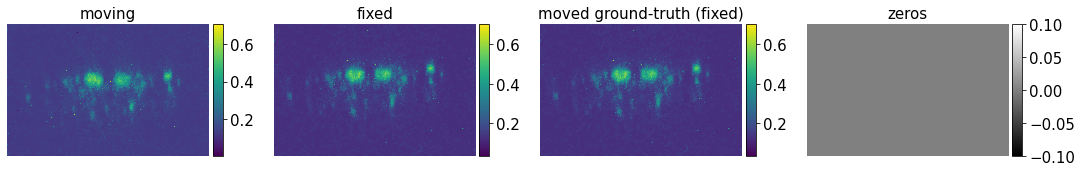

x_val.min()=0.012608264885422993 | x_val.max()=0.9202754961807664


In [54]:
batch_size = 16


x_train = tiff.imread(orig_examples[0], key=range(200))
x_train, (x_train_low, x_train_hig) = preprocessing(x_train)

# let's test it
np.random.seed(RANDOM_SEED)
train_generator = vxm_data_generator(x_train, batch_size=batch_size)
in_sample, out_sample = next(train_generator)

# visualize
images = [img[0, :, :, 0] for img in in_sample + out_sample] 
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['viridis', 'viridis', 'viridis', 'gray'], do_colorbars=True);

# validation
x_val = tiff.imread(orig_examples[1], key=range(200))
x_val = (x_val - x_train_low) / (x_train_hig - x_train_low)
print(f'{x_val.min()=} | {x_val.max()=}')

# let's get some data
val_generator = vxm_data_generator(x_val, batch_size=batch_size, training=True)

training,

In [51]:
import time
nb_epochs = 10
steps_per_epoch = 100
t1 = time.perf_counter()
hist = vxm_model.fit_generator(train_generator, epochs=nb_epochs, steps_per_epoch=steps_per_epoch,
                               validation_data=val_generator, validation_steps=(x_val.shape[0] // batch_size), verbose=2);
t2 = time.perf_counter()
print(f'Trained in {t2-t1:.2f}s')

Epoch 1/10
100/100 - 17s - loss: 5.3987e-04 - vxm_dense_transformer_loss: 4.4837e-04 - vxm_dense_flow_loss: 0.0018 - val_loss: 9.0384e-04 - val_vxm_dense_transformer_loss: 7.3792e-04 - val_vxm_dense_flow_loss: 0.0033
Epoch 2/10
100/100 - 16s - loss: 5.2772e-04 - vxm_dense_transformer_loss: 4.3973e-04 - vxm_dense_flow_loss: 0.0018 - val_loss: 9.2449e-04 - val_vxm_dense_transformer_loss: 7.6790e-04 - val_vxm_dense_flow_loss: 0.0031
Epoch 3/10
100/100 - 16s - loss: 5.1663e-04 - vxm_dense_transformer_loss: 4.3410e-04 - vxm_dense_flow_loss: 0.0017 - val_loss: 8.8504e-04 - val_vxm_dense_transformer_loss: 7.4543e-04 - val_vxm_dense_flow_loss: 0.0028
Epoch 4/10
100/100 - 16s - loss: 5.2871e-04 - vxm_dense_transformer_loss: 4.4209e-04 - vxm_dense_flow_loss: 0.0017 - val_loss: 9.1295e-04 - val_vxm_dense_transformer_loss: 7.3956e-04 - val_vxm_dense_flow_loss: 0.0035
Epoch 5/10
100/100 - 16s - loss: 5.2548e-04 - vxm_dense_transformer_loss: 4.3805e-04 - vxm_dense_flow_loss: 0.0017 - val_loss: 9.373

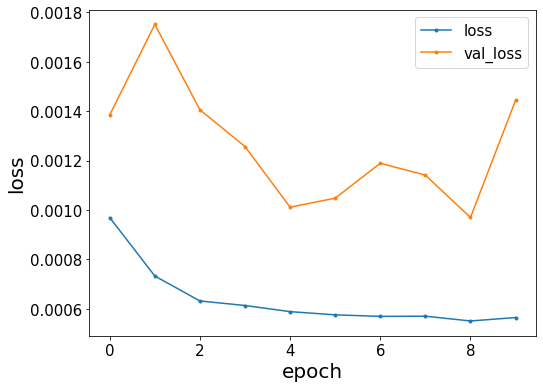

In [43]:
import matplotlib.pyplot as plt

def plot_history(hist, loss_names=['loss', 'val_loss']):
    # Simple function to plot training history.
    plt.style.use('ggpot2')
    plt.figure(figsize=(8, 6))
    for loss_name in loss_names:
        plt.plot(hist.epoch, hist.history[loss_name], '.-', label=loss_name)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()


plot_history(hist)

In [32]:
vxm_model.save_weights('../models/vxm_drosophila_2d.h5')

## Validation

In [33]:
from modules.utils import get_strategy
strategy = get_strategy('GPU')

[2021-11-26 13:31:59,289] I T140302596278080 utils.py:600: Num Physical GPUs Available: 1
[2021-11-26 13:31:59,289] I T140302596278080 utils.py:601: Num Logical  GPUs Available: 1
[2021-11-26 13:31:59,290] I T140302596278080 utils.py:602: Num TPUs Available: 0
[2021-11-26 13:31:59,290] W T140302596278080 utils.py:612: GPU device "PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')" is already initialized.


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


[2021-11-26 13:31:59,292] I T140302596278080 utils.py:628: using GPU "MirroredStrategy" strategy.


In [34]:
# retrieve dataset shape
PATH = orig_examples[0]
in_shape = tiff.imread(PATH, key=0).shape

In [35]:
# configure unet features 
nb_features = [
    [32, 32, 32, 64],         # encoder features
    [64, 32, 32, 16, 16, 16]  # decoder features
]

# build model using VxmDense
with strategy.scope():
    vxm_model = vxm.networks.VxmDense(in_shape, nb_features, int_steps=0)

In [36]:
vxm_model.load_weights('../models/vxm_drosophila_2d.h5')

validation video,

In [41]:
x_val = tiff.imread(orig_examples[0], key=range(200))
x_val, (x_val_low, x_val_hig) = preprocessing(x_val)

# let's get some data
val_generator = vxm_data_generator(x_val, batch_size=16, training=False)

In [42]:
import time
val_pred = []
t1 = time.perf_counter()
for (val_input, _) in val_generator:
    val_pred += [vxm_model.predict(val_input, verbose=2)]
t2 = time.perf_counter()
print(f'Registered in {t2-t1:.2f}s | {x_val.shape[0]/(t2-t1) : .0f} frames / s')
val_pred = [
    np.concatenate([a[0] for a in val_pred], axis=0),
    np.concatenate([a[1] for a in val_pred], axis=0)
]

1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
Registered in 1.70s |  118 frames / s


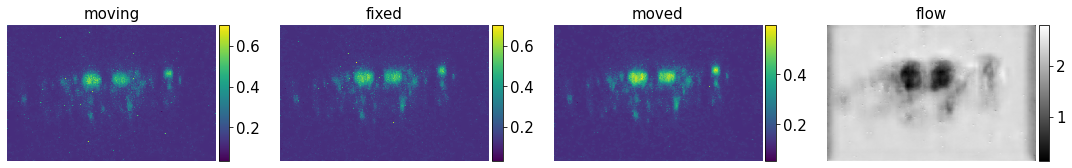

In [43]:
# visualize
images = [img[0, :, :, 0] for img in val_input + val_pred] 
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['viridis', 'viridis', 'viridis', 'gray'], do_colorbars=True);

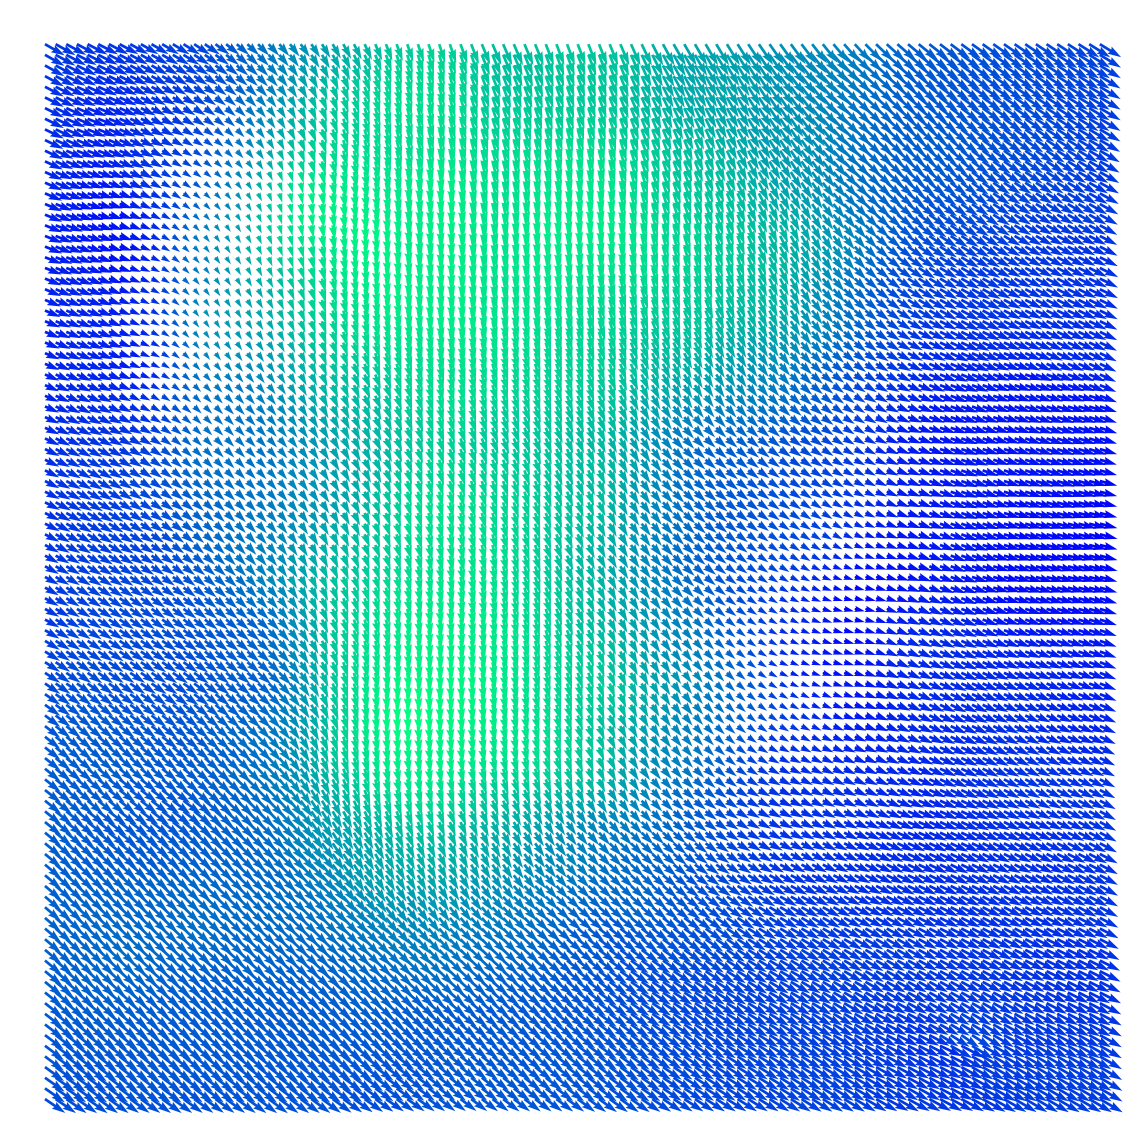

In [44]:
ne.plot.flow([val_pred[1][0, 150:250, 250:350, :].squeeze()], width=16);

In [45]:
make_video('out', frame_gen(val_pred[0]))
Video('out.mov')

calculated std


200it [00:00, 299.07it/s]


converting video..
Done (1.32s)


In [45]:
make_video('out', frame_gen(val_pred[0]))
Video('out.mov')

calculated std


200it [00:00, 299.07it/s]


converting video..
Done (1.32s)


# Visualize trained model

# Validation results

In [5]:
Video('../bin/train-voxelmorph.out/validation-video.mov')

[2021-12-04 00:05:14,743] I T140172250136960 utils.py:149: Calculated "mean" fixed references in 13.1s


x.shape=(4100, 480, 736)


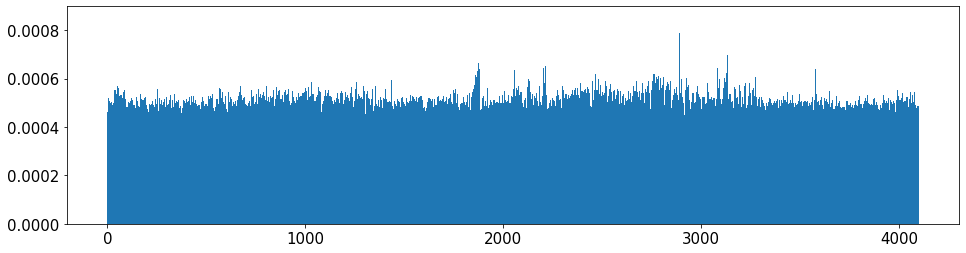

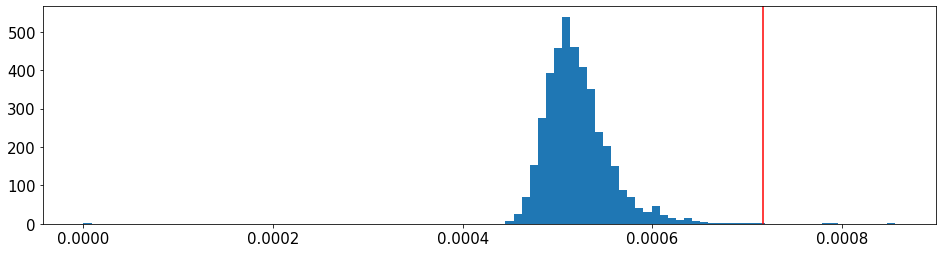

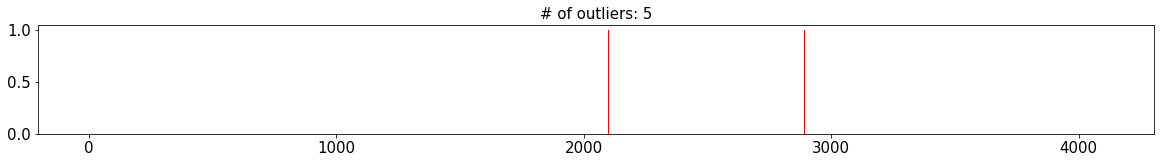

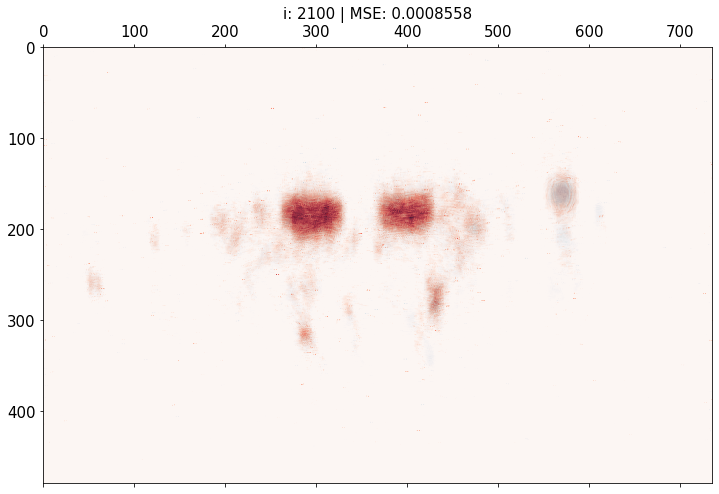

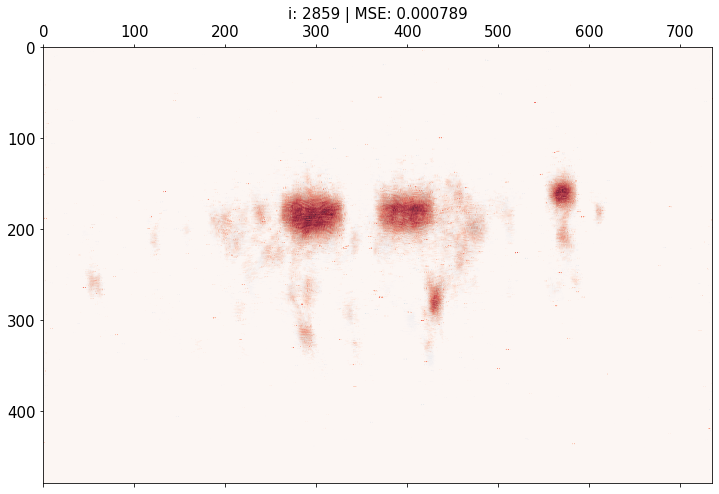

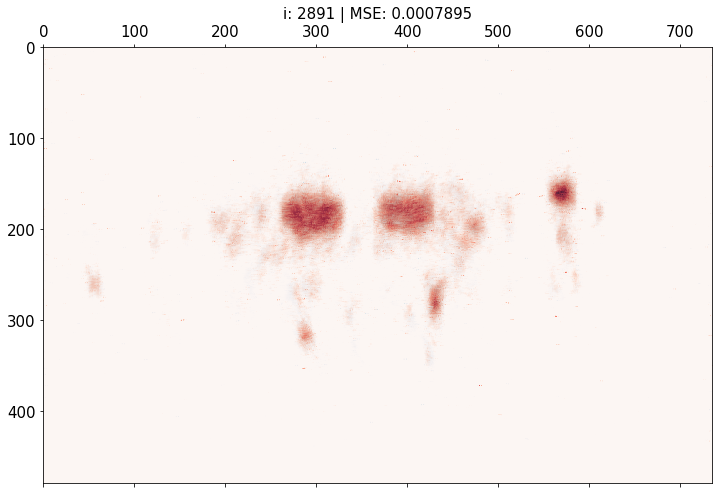

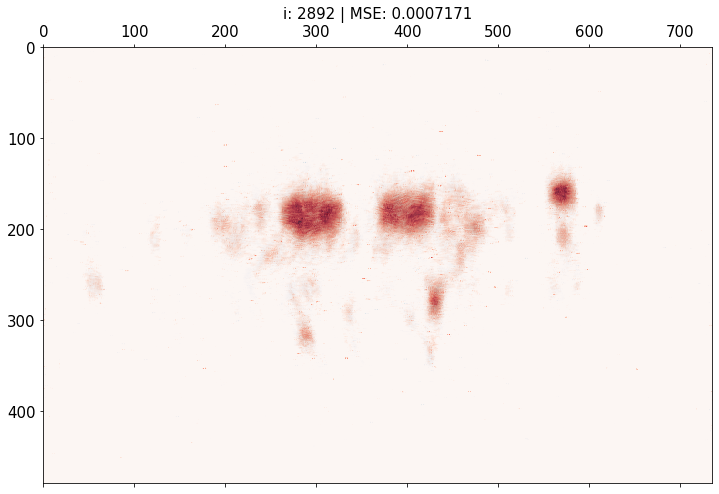

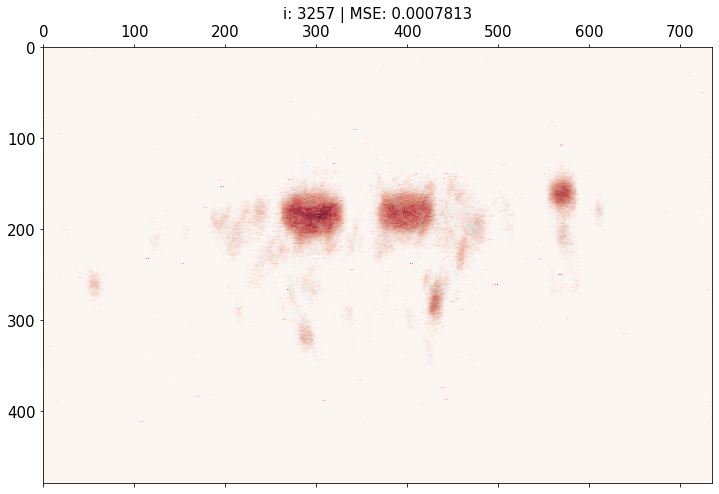

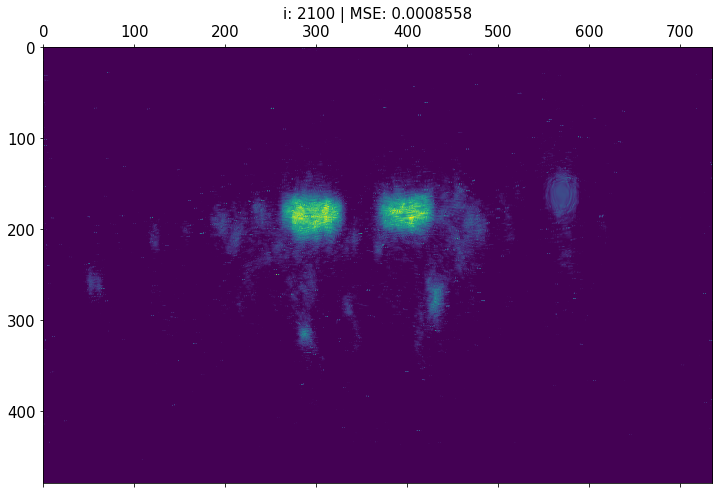

radius=48.0
x: 369.46 + 1.28
y: 199.82 + 0.59


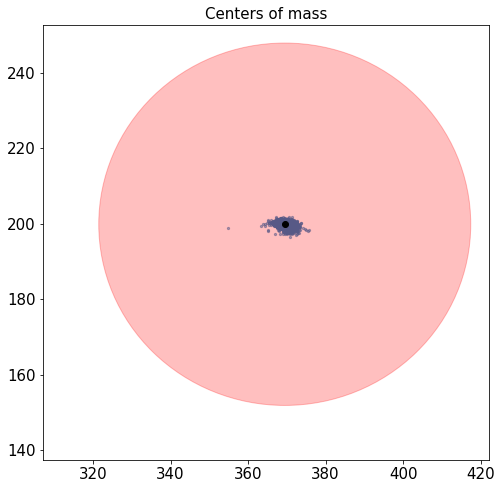

fails score: 0.0000%


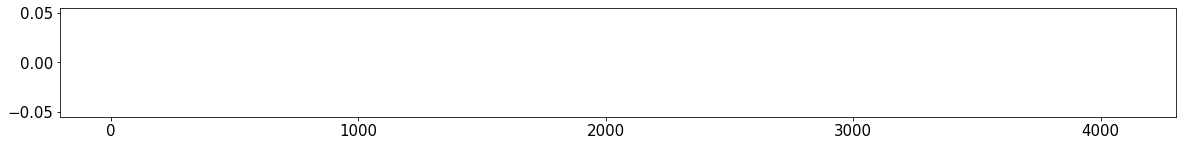

In [16]:
from stabilize2p.utils import plot_centers
from stabilize2p.metrics import MSE, COM
# x = np.load('../bin/train-voxelmorph.out/validation-video.npy')
# x = x[..., 0]
x = []
img_gen = vxm_data_generator(ofco_examples[4], batch_size=32,
                             affine_transform=False, training=False)
for ((batch, _), _) in img_gen:
    x += [batch[..., 0]]
x = np.concatenate(x, axis=0)
print(f'{x.shape=}')

# MSE
mse = MSE(x, ref='first', return_all=True)
plt.figure(figsize=(16, 4))                   # plot 1
plt.bar(np.arange(mse.size), mse, width=1)
plt.show()
mse_th = np.quantile(mse, q=0.999)
plt.figure(figsize=(16, 4))                   # plot 2
plt.hist(mse.ravel(), bins=100)
plt.axvline(mse_th, color='red')
plt.show()
outliers = (mse > mse_th).astype(int)
plt.figure(figsize=(20, 2))                   # plot 3
plt.bar(np.arange(outliers.size), outliers, width=1, color='r')
plt.title(f'# of outliers: {np.sum(outliers)}')
plt.show()
for i in np.where(mse > mse_th)[0]:
    _, ax = plt.subplots(1, 1, figsize=(12, 10))  # plot 4
    ax.matshow(x[0], cmap='Blues')
    ax.matshow(x[i], cmap='Reds', alpha=0.75)
    plt.title(f'i: {i} | MSE: {mse[i]:.4g}')
    plt.show()
i = np.argmax(mse)
_, ax = plt.subplots(1, 1, figsize=(12, 10))  # plot 5
ax.matshow(x[i])
plt.title(f'i: {i} | MSE: {mse[i]:.4g}')
plt.show()


# COM
plt.figure(figsize=(8, 8))
plot_centers(x)
plt.show()

fails = COM(x, return_all=True)
print(f'fails score: {np.sum(fails)/fails.shape[0]*100:.4f}%')
plt.figure(figsize=(20, 2))
plt.bar(np.arange(fails.size), fails.astype(int), color='tab:red')
plt.show()

In [24]:
from stabilize2p import threshold
image = tiff.imread(orig_examples[4], key=range(2050, 2150))
# th = threshold.triangle(image[0])
# np.clip(image, th, None, out=image)
# image = image - th

make_video('out', frame_gen(image))

# img = tiff.imread(orig_examples[4], key=2100)
# th = threshold.triangle(img)
# np.clip(img, th, None, out=img)
# img = img - th
# _, ax = plt.subplots(1,1, figsize=(12, 10))
# ax.matshow(img)
# plt.show()

Video('out.mov')

calculated std


100it [00:00, 213.41it/s]
ffmpeg: /home/adrian/miniconda3/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


converting video..
Done (0.90s)


# `vxm_data_generator` exploration

## Reference image

[2021-12-02 14:20:39,974] W T139921323819392 utils.py:194: pixel histogram is uni-modal, estimated threshold may not be accurate.


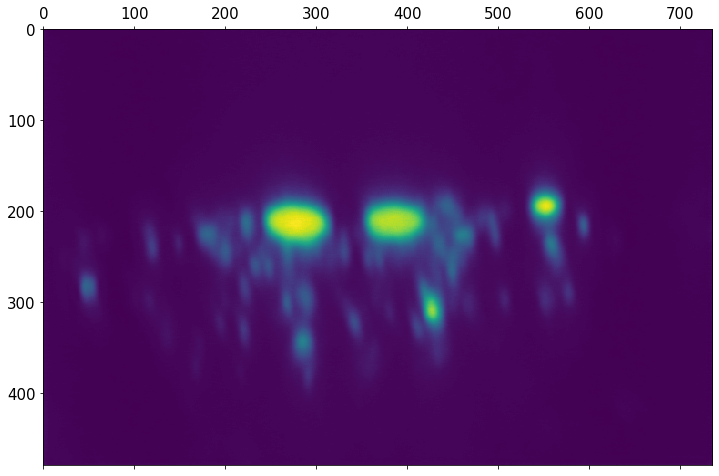

In [18]:
from stabilize2p.utils import vxm_preprocessing
path = "../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.tif"
x_val = tiff.imread(path, key=range(200))
x_val, _ = vxm_preprocessing(x_val)
img = np.mean(x_val, axis=0)

_, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.matshow(img)
plt.show()

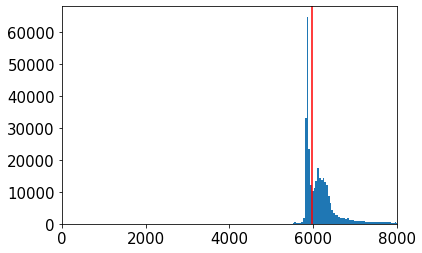

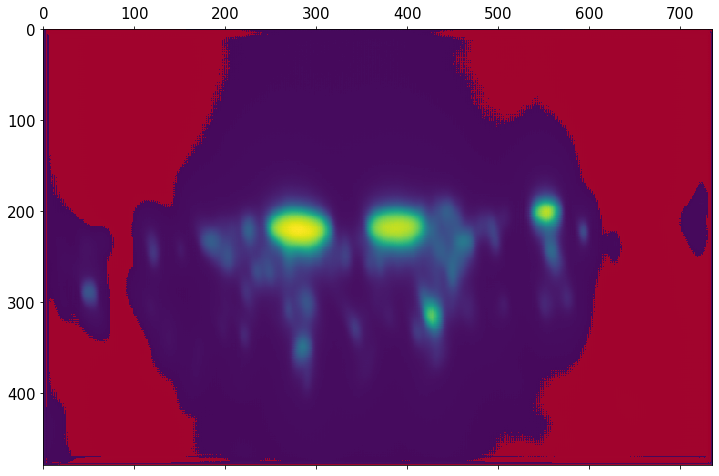

In [21]:
from stabilize2p.utils import estimate_background_threshold

th = estimate_background_threshold(img)
mask = (img < th).astype(float) * 0.5
mask = np.tile(mask[..., np.newaxis], (1, 1, 4))
mask[..., 0] = 1.0
mask[..., [1, 2]] = 0.0

plt.hist(img.ravel(), bins=800)
plt.axvline(th, c='r')
plt.xlim(0, 8000)
plt.show()

_, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.matshow(img)
ax.matshow(mask)

generated validation video,

## Generate videos

x: 367.79 + 0.83
y: 236.88 + 0.62


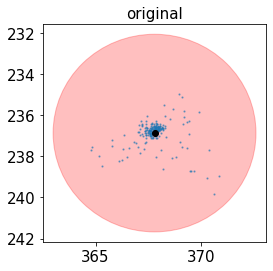

25it [00:04,  5.80it/s]


generated x
x: 375.23 + 2.03
y: 208.18 + 0.71


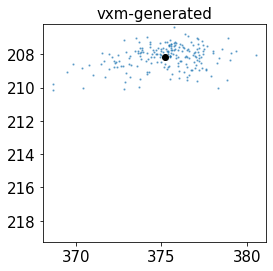

calculated std


200it [00:00, 380.65it/s]
ffmpeg: /home/adrian/miniconda3/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


converting video..
Done (0.85s)
x: 368.25 + 3.31
y: 234.51 + 1.57


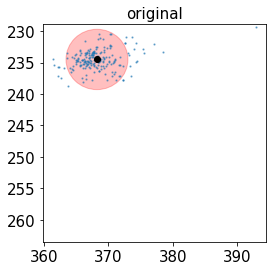

25it [00:04,  5.75it/s]


generated x
x: 375.16 + 1.89
y: 212.07 + 0.75


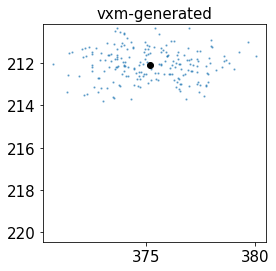

calculated std


200it [00:00, 378.78it/s]
ffmpeg: /home/adrian/miniconda3/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


converting video..
Done (0.87s)
x: 367.18 + 0.46
y: 238.17 + 0.31


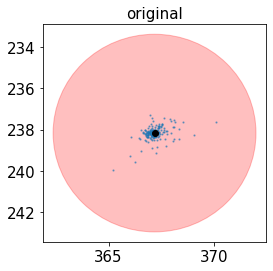

25it [00:04,  5.64it/s]


generated x
x: 365.21 + 2.09
y: 223.65 + 0.49


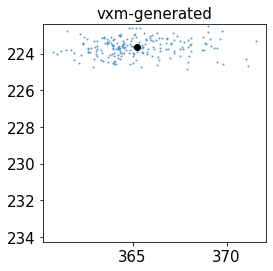

calculated std


200it [00:00, 348.24it/s]
ffmpeg: /home/adrian/miniconda3/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


converting video..
Done (1.02s)
x: 366.56 + 0.22
y: 239.36 + 0.15


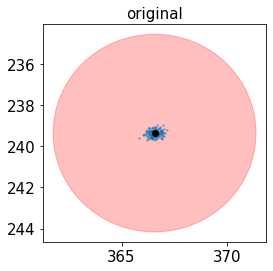

25it [00:04,  5.79it/s]


generated x
x: 363.86 + 1.59
y: 232.72 + 0.42


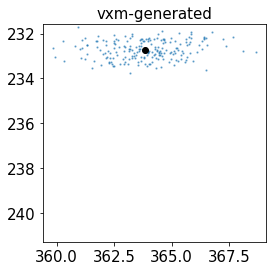

calculated std


200it [00:00, 378.66it/s]
ffmpeg: /home/adrian/miniconda3/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


converting video..
Done (0.90s)
x: 365.66 + 2.23
y: 240.42 + 0.95


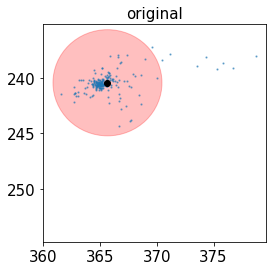

25it [00:04,  5.77it/s]


generated x
x: 360.89 + 2.34
y: 239.66 + 0.56


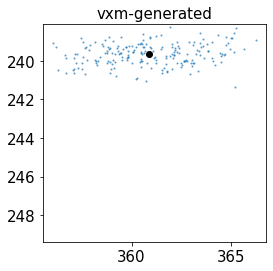

calculated std


200it [00:00, 381.51it/s]
ffmpeg: /home/adrian/miniconda3/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


converting video..
Done (0.86s)


In [12]:
import os
import logging
from tqdm import tqdm
from stabilize2p.utils import vxm_data_generator, plot_centers
logging.getLogger('stabilize2p').setLevel(logging.ERROR)

os.makedirs('vxm_generated', exist_ok=True)

# path = "../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.tif"
for i, path in enumerate(orig_examples):
    keys = [range(1400, 1600)]

    x = tiff.imread(path, key=keys[0])
    plot_centers(x); plt.title('original'); plt.show()

    x = []
    for (ins, _) in tqdm(vxm_data_generator(path, keys=keys, training=False)):
        batch, _ = ins
        x += [batch]

    x = np.concatenate(x, axis=0)
    print('generated x')

    plot_centers(x); plt.title('vxm-generated'); plt.show()

    make_video(f'vxm_generated/raw_{i}', frame_gen(x))

In [15]:
make_video('out', frame_gen(tiff.imread(orig_examples[0], key=range(1400, 1600))))
Video('out.mov')

calculated std


200it [00:00, 256.58it/s]
ffmpeg: /home/adrian/miniconda3/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


converting video..
Done (1.41s)


In [16]:
Video('vxm_generated/raw_4.mov')

## Detecting failures

0it [00:00, ?it/s][2021-12-03 20:58:05,476] I T139963095155520 utils.py:150: Calculated "mean" fixed references in 1.56s
75it [00:13,  5.71it/s]


generated x, x.shape=(600, 480, 736)
fails: 0.0000%


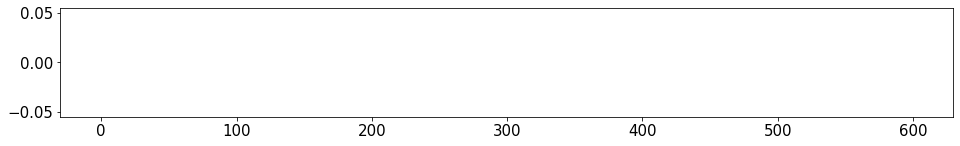

radius=48.0
x: 378.48 + 2.52
y: 208.62 + 0.69


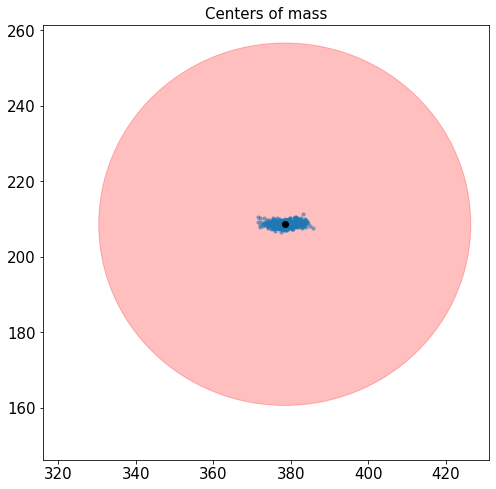

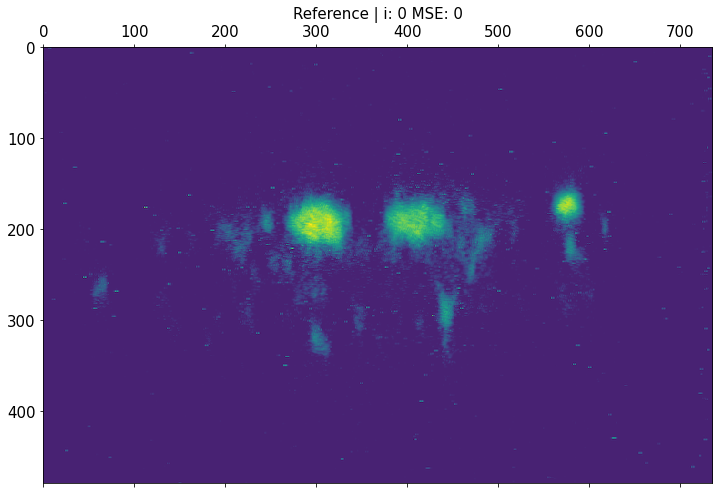

calculated std


600it [00:01, 398.80it/s]
ffmpeg: /home/adrian/miniconda3/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


converting video..
Done (2.33s)


In [118]:
from scipy.stats import norm
from tqdm import tqdm
from stabilize2p import threshold
from stabilize2p.utils import plot_centers
from stabilize2p.metrics import MSE, NCC, COM
from matplotlib.patches import Patch

path = orig_examples[0]
keys = [range(1000, 1600)]

x = []
for (ins, _) in tqdm(vxm_data_generator(path, keys=keys, training=False)):
    batch, _ = ins
    x += [batch]
x = np.concatenate(x, axis=0)[..., 0]
print(f'generated x, {x.shape=}')

fails = COM(x, return_all=True)
print(f'fails: {np.sum(fails)*100:.4f}%')

plt.figure(figsize=(16, 2))
plt.bar(np.arange(fails.size), fails.astype(int), color='tab:red')
plt.show()

plt.figure(figsize=(8, 8))
plot_centers(x, s=10)

mse = MSE(x, ref='previous', return_all=True)

_, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.matshow(x[0])
plt.title(f'Reference | i: {0} MSE: {mse[0]:,.0f}')
plt.show()

idx = np.where(fails)[0]
for i, outlier_frame in enumerate(x[idx][:5]):
    _, ax = plt.subplots(1, 1, figsize=(12, 10))
    ax.matshow(x[0], cmap='Blues')
    ax.matshow(outlier_frame, cmap='Reds', alpha=0.5)

    ax.legend(handles=[
        Patch(facecolor='tab:blue', label='reference'),
        Patch(facecolor='tab:red', label='outlier')
    ])

    plt.title(f'i: {idx[i]} MSE: {mse[idx[i]]:,.0f}')
    plt.show()

make_video('out', frame_gen(x))
Video('out.mov')

## Re-plot history

dict_keys(['epoch', 'history'])
final validation score:  0.000203588861040771


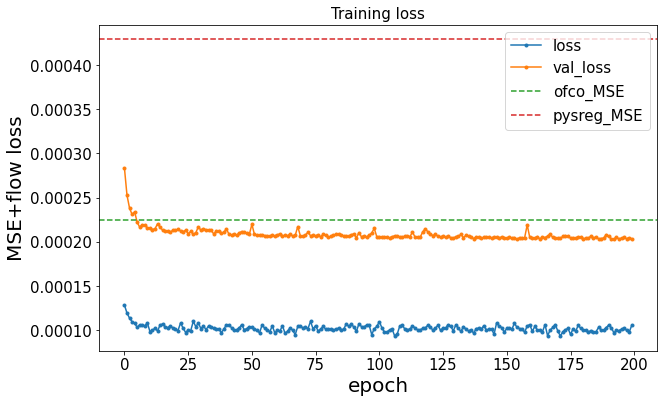

In [25]:
import pickle
from itertools import cycle

config = {
    'reference_losses': {
        "ofco_MSE": 0.00022515207302422938,
        "pysreg_MSE": 0.00042895964151606436
    }
}


def plot_history(hist, loss_names=['loss', 'val_loss']):
    # Simple function to plot training history.
    plt.figure(figsize=(10, 6))

    color = plt.cm.tab10(np.linspace(0, 1, 10))
    c = cycle(color)

    # training losses
    for loss_name in loss_names:
        if loss_name in hist["history"]:
            plt.plot(hist["epoch"], hist["history"][loss_name], '.-', c=next(c), label=loss_name)

    # user-provided reference losses
    for label, value in config["reference_losses"].items():
        plt.axhline(value, label=label, ls='--', c=next(c))

    plt.ylabel('MSE+flow loss')
    plt.xlabel('epoch')
    plt.title('Training loss')
    plt.legend()


with open('../bin/train-voxelmorph.out/history.pkl', 'rb') as f:
    hist = pickle.load(f)
    print(hist.keys())
    print('final validation score: ', hist['history']['val_loss'][-1])
plot_history(hist)

# Scoring

We follow the same scoring procedure as in Voxelmorph.

MSE,

In [5]:
import voxelmorph as vxm
from stabilize2p.utils import vxm_data_generator

In [6]:
import logging
from tqdm import tqdm
logging.getLogger('stabilize2p').setLevel(logging.INFO)

path = pystackreg_examples[4]
print(f'{path=}')
img_gen = vxm_data_generator(path, batch_size=32, affine_transform=False, training=False)
MSE_loss = vxm.losses.MSE().loss
mse = []
t1 = time.perf_counter()
for (ins, _) in tqdm(img_gen):
    moved, fixed = ins
    mse += [MSE_loss(moved, fixed).numpy()]
mse = np.mean(mse)
t2 = time.perf_counter()

print(f'pysreg MSE: {mse} | {t2-t1:.3g}s')

path='../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.pystackreg-affine.tif'


0it [00:00, ?it/s][2021-12-03 22:34:56,929] I T139718491677056 utils.py:149: Calculated "mean" fixed references in 164s
2021-12-03 22:34:57.095765: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-03 22:34:57.096122: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-03 22:34:57.105643: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-03 22:34:57.105965: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


pysreg MSE: 0.00042895964151606436 | 286s


In [7]:
import logging
import voxelmorph as vxm
from stabilize2p.utils import vxm_data_generator
from tqdm import tqdm
logging.getLogger('stabilize2p').setLevel(logging.INFO)

path = ofco_examples[4]
print(f'{path=}')
img_gen = vxm_data_generator(path, batch_size=32, affine_transform=False, training=False)
MSE_loss = vxm.losses.MSE().loss
mse = []
t1 = time.perf_counter()
for (ins, _) in tqdm(img_gen):
    moved, fixed = ins
    mse += [MSE_loss(moved, fixed).numpy()]
mse = np.mean(mse)
t2 = time.perf_counter()

print(f'ofco MSE: {mse} | {t2-t1:.3g}s')

path='../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/warped_red.tif'


0it [00:00, ?it/s][2021-12-03 22:39:42,106] I T140172250136960 utils.py:149: Calculated "mean" fixed references in 22.7s
2021-12-03 22:39:42.248451: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-03 22:39:42.248817: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-03 22:39:42.253096: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-03 22:39:42.253436: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

ofco MSE: 0.00022515207302422938 | 38.7s


x: 364.76 + 1.12
y: 239.72 + 1.05


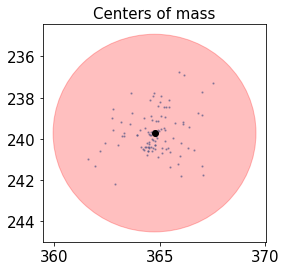

slice(0, 100, None)
31 frames/s | 0.0323 s/frame | MSE: 3,157,220.2 | NCC: -1.18171e+11
x: 364.51 + 1.78
y: 241.00 + 2.47


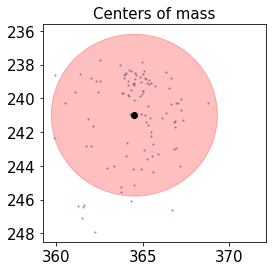

calculated std


100it [00:00, 254.69it/s]
ffmpeg: /home/adrian/miniconda3/lib/libtinfo.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)
ffmpeg: /home/adrian/miniconda3/lib/libncursesw.so.6: no version information available (required by /lib/x86_64-linux-gnu/libcaca.so.0)


converting video..
Done (0.93s)


In [84]:
from stabilize2p.utils import estimate_background_threshold, plot_centers
from stabilize2p.register import com_transform, pysreg_transform, ECC_transform
from stabilize2p.metrics import MSE, NCC

path = "../data/200901_G23xU1/Fly1/Fly1/005_coronal/2p/denoised_red.tif"
x_val = tiff.imread(path, key=range(600, 700))

plot_centers(x_val)

t1 = time.perf_counter()
# com_transform(x_val, inplace=True, downsample=2)  # 313 frames/s | 0.0032 s/frame | MSE: 3,555,150.2 | NCC: -5.05929e+09
# x_val = pysreg_transform(x_val)                   # 4 frames/s | 0.273 s/frame | MSE: 3,977,842.2 | NCC: -2.22524e+11
x_val = ECC_transform(x_val)                        # 31 frames/s | 0.0324 s/frame | MSE: 3,157,220.2 | NCC: -1.18171e+11
t2 = time.perf_counter()
mse, ncc = MSE(x_val), NCC(x_val)
print(f'{x_val.shape[0]/(t2-t1):.0f} frames/s | {(t2-t1)/x_val.shape[0]:.3g} s/frame | '
      f'MSE: {mse:,.8g} | NCC: {ncc:,.6g}')

plot_centers(x_val)

# t1 = time.perf_counter()
# com_transform(x_val, inplace=True, downsample=2)  # 356 frames/s | 0.00281 s/frame
# # x_val = pysreg_transform(x_val)                 # 7 frames/s | 0.145 s/frame
# t2 = time.perf_counter()
# print(f'{x_val.shape[0]/(t2-t1):.0f} frames/s | {(t2-t1)/x_val.shape[0]:.3g} s/frame')

# plot_centers(x_val)

make_video('out', frame_gen(x_val))
Video('out.mov')